In [1]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data_9dep.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4th,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2nd,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4th,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3rd,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5th,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2nd,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4th,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3rd,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3rd,September,130,82


In [2]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculating MAE, RMSE, MSE, and R² for the surgeon's estimated operation time
surgeon_mae = mean_absolute_error(df['surgery duration'], df['surgeon estimated op time'])
surgeon_rmse = np.sqrt(mean_squared_error(df['surgery duration'], df['surgeon estimated op time']))
surgeon_mse = mean_squared_error(df['surgery duration'], df['surgeon estimated op time'])
surgeon_r2 = r2_score(df['surgery duration'], df['surgeon estimated op time'])

surgeon_mae, surgeon_rmse, surgeon_mse, surgeon_r2

(70.8192520732668, 94.3469303146079, 8901.343259789479, 0.2590043404892589)

In [3]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type',
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value', 'surgeon id', 'ward', 
                'admission department', 'surgery room', 'op code']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

cross_val_scores_rf = {}

# Preparing department-specific datasets
departments = df['surgical department'].unique()
department_models = {}
predictions = {}


# Training models for each department
for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration'] 

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model with cross-validation
    department_model = RandomForestRegressor(random_state=42)
    cv_scores_rf = cross_val_score(department_model, X_dept, y_dept, cv=5)
    cross_val_scores_rf[dept] = cv_scores_rf.mean()

    # Training and saving the final model
    department_model.fit(X_train_dept, y_train_dept)
    department_models[dept] = department_model

    # Making predictions on the test dataset
    predictions[dept] = department_model.predict(X_test_dept)


# Preparing for ensemble
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, department_model in department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# Evaluating performance
mae_rf = mean_absolute_error(y_test_all, final_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_rf = r2_score(y_test_all, final_predictions)

# The code is now updated with model names changed to 'department_model'
mae_rf, rmse_rf, r2_rf

print(f"Ensemble MAE: {mae_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")

In [ ]:
# Retraining the models with the default parameters of RandomForestRegressor
default_models = {}
default_predictions = {}
default_mae = {}
dept_sample_counts = {}
actual_surgery_durations = {}

for dept in departments:
    dept_col_name = 'surgical department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    
    # Storing the number of samples per department
    dept_sample_counts[dept] = len(dept_data)

    if len(dept_data) > 0:
        X_dept = dept_data.drop('surgery duration', axis=1)
        y_dept = dept_data['surgery duration']

        # Actual surgery durations for each department
        actual_surgery_durations[dept] = y_dept

        # Splitting the data for the department
        X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

        # Training the model with default parameters
        default_model = RandomForestRegressor(random_state=42)
        default_model.fit(X_train_dept, y_train_dept)
        default_models[dept] = default_model

        # Predicting on the test set
        dept_predictions = default_model.predict(X_test_dept)
        default_predictions[dept] = dept_predictions

        # Calculating MAE for each department
        dept_mae = mean_absolute_error(y_test_dept, dept_predictions)
        default_mae[dept] = dept_mae

# Preparing the data for visualization
dept_data_for_visualization = pd.DataFrame({
    'Department': default_mae.keys(),
    'MAE': default_mae.values(),
    'Sample Count': [dept_sample_counts[dept] for dept in default_mae.keys()],
    'Average Surgery Duration': [actual_surgery_durations[dept].mean() for dept in default_mae.keys()]
})

dept_data_for_visualization.sort_values(by='Department')

,Department,MAE,Sample Count,Average Surgery Duration
8,Cardiovascular Thoracic Surgery,48.856469,9341,233.352425
0,General Surgery,35.513814,36466,155.665771
7,Neurosurgery,49.642636,7187,239.383053
4,Obstetrics & Gynecology,34.699900,11510,131.534839
3,Ophthalmology,12.906626,17437,57.755921
2,Orthopedics,34.596868,16617,133.923572
1,Otolaryngology,44.702501,11772,139.036018
16,Pediatric Neurosurgery,65.318504,1166,296.249571
14,Pediatric Ophthalmology,10.321978,7857,56.627339
10,Pediatric Orthopedics,49.609155,3905,143.927017


In [ ]:
# Extracting predictions and actual values for the 'General Surgery' department
dept_name = 'General Surgery'
general_surgery_predictions = default_predictions[dept_name]
general_surgery_actual = actual_surgery_durations[dept_name]

# Adjusting to use only the test set data for General Surgery department
dept_col_name = 'surgical department_' + dept_name
dept_test_data = df_encoded[df_encoded[dept_col_name] == 1]

# Splitting the data for the department again to get the test set
_, X_test_dept, _, y_test_dept = train_test_split(dept_test_data.drop('surgery duration', axis=1), 
                                                  dept_test_data['surgery duration'], 
                                                  test_size=0.2, 
                                                  random_state=42)

# Extracting the actual surgery durations from the test set
general_surgery_actual_test = y_test_dept

# Creating a DataFrame for detailed analysis with test set data
general_surgery_analysis_test = pd.DataFrame({
    'Actual Duration': general_surgery_actual_test,
    'Predicted Duration': general_surgery_predictions
})

# Calculating the difference between actual and predicted values
general_surgery_analysis_test['Difference'] = general_surgery_analysis_test['Actual Duration'] - general_surgery_analysis_test['Predicted Duration']
general_surgery_analysis_test['Absolute Difference'] = abs(general_surgery_analysis_test['Difference'])

# Sorting the DataFrame by absolute difference
general_surgery_analysis_test_sorted = general_surgery_analysis_test.sort_values(by='Absolute Difference', ascending=False)

general_surgery_analysis_test_sorted.head(10)  # Displaying the top 10 entries with the largest differences



,Actual Duration,Predicted Duration,Difference,Absolute Difference
3621,765,103.06,661.94,661.94
140705,1044,507.04,536.96,536.96
150188,690,194.60,495.40,495.40
70228,810,353.42,456.58,456.58
150483,612,161.51,450.49,450.49
59073,810,375.43,434.57,434.57
16009,613,184.82,428.18,428.18
135450,462,888.32,-426.32,426.32
114050,685,288.49,396.51,396.51
99362,540,150.46,389.54,389.54


In [ ]:
# Calculating the absolute difference for the entire dataset
# First, we need to predict for the entire dataset using the trained models for each department
all_predictions = []

# Loop through each department, predict, and store the results
for dept in departments:
    dept_col_name = 'surgical department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]

    if len(dept_data) > 0:
        X_dept = dept_data.drop(['surgery duration', 'Predicted Duration', 'Absolute Difference'], axis=1, errors='ignore')
        model = default_models[dept]
        dept_predictions = model.predict(X_dept)
        all_predictions.extend(dept_predictions)

# Add the predictions to the original dataframe
df_encoded['Predicted Duration'] = all_predictions

# Calculate the absolute difference for the entire dataset
df_encoded['Absolute Difference'] = abs(df_encoded['surgery duration'] - df_encoded['Predicted Duration'])

# Sorting by highest errors
sorted_by_error = df_encoded.sort_values(by='Absolute Difference', ascending=False)

# Extracting top error data points for analysis (e.g., top 10%)
top_error_percentile = 90
top_error_threshold = np.percentile(sorted_by_error['Absolute Difference'], top_error_percentile)
top_error_data = sorted_by_error[sorted_by_error['Absolute Difference'] >= top_error_threshold]

# Analyzing common characteristics in top error data points
top_error_analysis = top_error_data.describe(include='all')

top_error_analysis



,age,BMI,condition source value,surgery duration,surgical department_Cardiovascular Thoracic Surgery,surgical department_General Surgery,surgical department_Neurosurgery,surgical department_Obstetrics & Gynecology,surgical department_Ophthalmology,surgical department_Orthopedics,...,op code_P00008435,op code_P00008439,op code_P00008446,op code_P00008447,op code_P00008448,op code_P00008449,op code_P00008450,op code_P00008456,Predicted Duration,Absolute Difference
count,16123.000000,16123.000000,16123.000000,16123.000000,16123,16123,16123,16123,16123,16123,...,16123,16123,16123,16123,16123,16123,16123,16123,16123.000000,16123.00000
unique,NaN,NaN,NaN,NaN,2,2,2,2,2,2,...,1,2,1,2,1,1,1,1,NaN,NaN
top,NaN,NaN,NaN,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,NaN,NaN
freq,NaN,NaN,NaN,NaN,14094,12838,14789,15408,15062,15062,...,16123,16120,16123,16122,16123,16123,16123,16123,NaN,NaN
mean,47.703529,23.166315,2316.051479,269.406686,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.339906,354.07959
std,26.883813,13.382799,1555.083310,209.554704,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185.020096,105.94915
min,1.000000,1.015471,18.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.070000,249.66000
25%,19.000000,19.086275,741.000000,65.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.255000,279.75000
50%,56.000000,22.811570,2273.000000,309.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.910000,321.54000
75%,70.000000,25.406302,3638.000000,419.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,387.925000,393.91000


In [ ]:
# Calculating the absolute error and error percentage for the top error data
top_error_data['Absolute Error'] = abs(top_error_data['surgery duration'] - top_error_data['Predicted Duration'])
top_error_data['Error Percentage'] = (top_error_data['Absolute Error'] / top_error_data['surgery duration']) * 100

# Summary of the absolute error and error percentage
error_summary = top_error_data[['Absolute Error', 'Error Percentage']].describe()
error_summary

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36700\4051699312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_error_data['Absolute Error'] = abs(top_error_data['surgery duration'] - top_error_data['Predicted Duration'])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36700\4051699312.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_error_data['Error Percentage'] = (top_error_data['Absolute Error'] / top_error_data['surgery duration']) * 100


,Absolute Error,Error Percentage
count,16123.00000,16123.000000
mean,354.07959,339.495981
std,105.94915,393.664380
min,249.66000,36.450210
25%,279.75000,82.623240
50%,321.54000,92.781532
75%,393.91000,515.634241
max,1579.72000,8446.800000


In [ ]:
def calculate_weighted_error_rate(df, column_prefix, excluded_categories=[]):
    one_hot_columns = [col for col in df.columns if col.startswith(column_prefix) and col not in excluded_categories]

    sample_counts = {col: df[col].sum() for col in one_hot_columns}
    weights = {col: 1/count if count > 0 else 0 for col, count in sample_counts.items()}
    total_weight = sum(weights.values())
    normalized_weights = {col: weight/total_weight for col, weight in weights.items()}

    weighted_error_rates = {}
    for col in one_hot_columns:
        category_data = df[df[col] == 1]
        if len(category_data) > 0:
            error_rate = mean_absolute_error(category_data['surgery duration'], category_data['Predicted Duration'])
            weighted_error_rates[col.split('_', 1)[-1]] = error_rate * normalized_weights[col]

    return weighted_error_rates

# 수정된 가중 오류율 계산
excluded = ['day of the week_Sunday', 'day of the week_Saturday', 'week of the month_5th']
day_of_week_error_rates = calculate_weighted_error_rate(df_encoded, 'day of the week_', excluded)
week_of_month_error_rates = calculate_weighted_error_rate(df_encoded, 'week of the month_', excluded)
month_error_rates = calculate_weighted_error_rate(df_encoded, 'month_', excluded)

# 시각화 코드는 동일하게 사용할 수 있습니다.


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36700\4189639851.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weighted Error Rate', y='Category', data=week_of_month_df, palette="viridis")


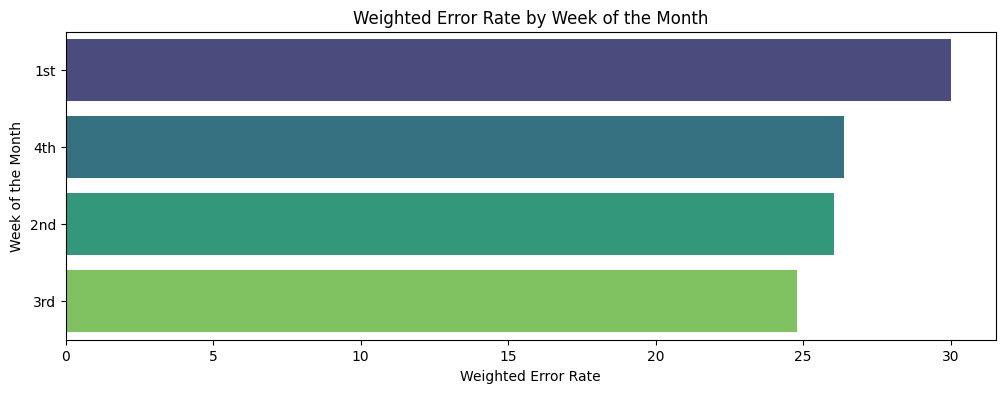

{'1st': 30.02045172926903,
 '2nd': 26.03440132946957,
 '3rd': 24.77426512288214,
 '4th': 26.374736238773867}

In [ ]:
# Creating DataFrame for 'Week of the Month' with updated weighted error rates
week_of_month_df = pd.DataFrame(week_of_month_error_rates.items(), columns=['Category', 'Weighted Error Rate'])
week_of_month_df = week_of_month_df.sort_values('Weighted Error Rate', ascending=False)

# Plotting 'Week of the Month' as a horizontal bar chart
plt.figure(figsize=(12, 4))
sns.barplot(x='Weighted Error Rate', y='Category', data=week_of_month_df, palette="viridis")
plt.title('Weighted Error Rate by Week of the Month')
plt.xlabel('Weighted Error Rate')
plt.ylabel('Week of the Month')
plt.show()

week_of_month_error_rates

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36700\3330635334.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weighted Error Rate', y='Category', data=month_df, palette="viridis")


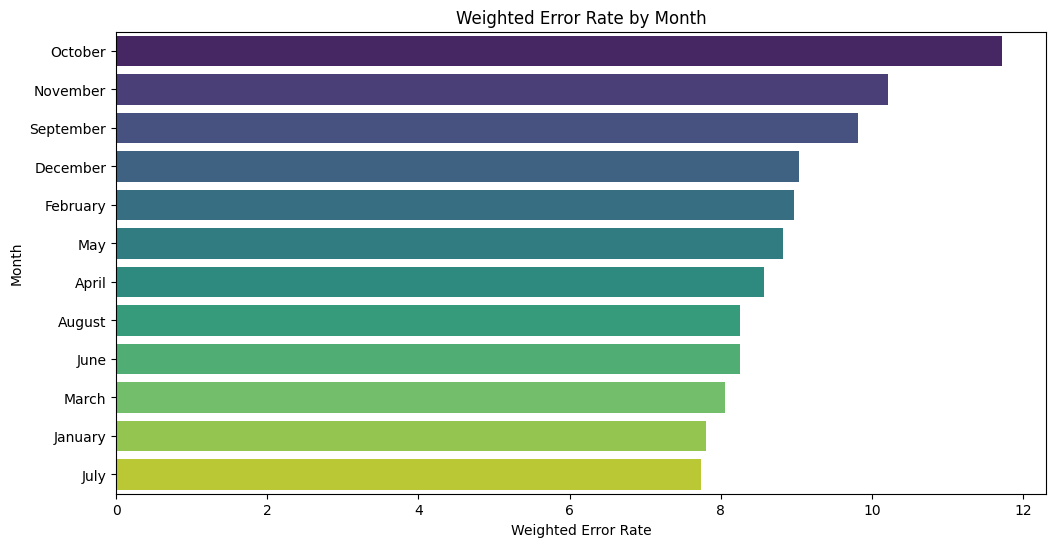

{'April': 8.577479753394266,
 'August': 8.256461655161097,
 'December': 9.039742200719287,
 'February': 8.96896209713679,
 'January': 7.798550030740631,
 'July': 7.744348682023927,
 'June': 8.253678590830978,
 'March': 8.056576436362077,
 'May': 8.821524654911185,
 'November': 10.208261691993375,
 'October': 11.716149868010014,
 'September': 9.819788148019063}

In [ ]:
# Creating DataFrame for 'Month' with updated weighted error rates
month_df = pd.DataFrame(month_error_rates.items(), columns=['Category', 'Weighted Error Rate'])
month_df = month_df.sort_values('Weighted Error Rate', ascending=False)

# Plotting 'Month' as a horizontal bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Weighted Error Rate', y='Category', data=month_df, palette="viridis")
plt.title('Weighted Error Rate by Month')
plt.xlabel('Weighted Error Rate')
plt.ylabel('Month')
plt.show()

month_error_rates

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36700\648903197.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weighted Error Rate', y='Category', data=surgical_department_df, palette="viridis")


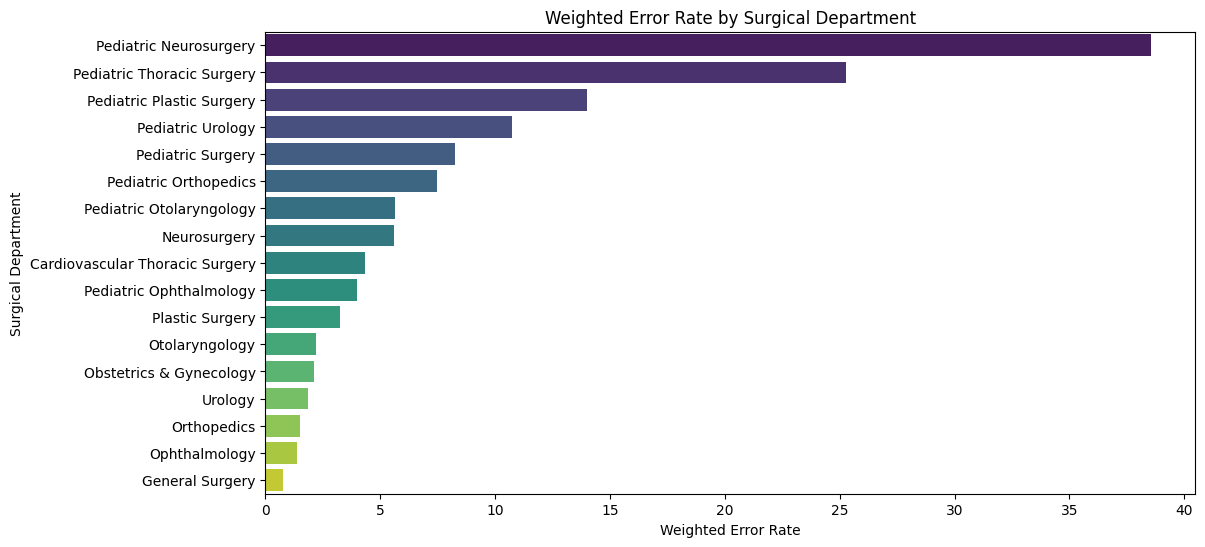

surgical department_Cardiovascular Thoracic Surgery     9341
surgical department_General Surgery                    36466
surgical department_Neurosurgery                        7187
surgical department_Obstetrics & Gynecology            11510
surgical department_Ophthalmology                      17437
surgical department_Orthopedics                        16617
surgical department_Otolaryngology                     11772
surgical department_Pediatric Neurosurgery              1166
surgical department_Pediatric Ophthalmology             7857
surgical department_Pediatric Orthopedics               3905
surgical department_Pediatric Otolaryngology            5764
surgical department_Pediatric Plastic Surgery           2124
surgical department_Pediatric Surgery                   4021
surgical department_Pediatric Thoracic Surgery          1876
surgical department_Pediatric Urology                   2975
surgical department_Plastic Surgery                     8460
surgical department_Urol

In [ ]:
def calculate_weighted_error_rate(df, column_prefix, max_weight_threshold=None):
    one_hot_columns = [col for col in df.columns if col.startswith(column_prefix)]

    sample_counts = {col: df[col].sum() for col in one_hot_columns}
    weights = {col: 1/count if count > 0 else 0 for col, count in sample_counts.items()}
    
    # max_weight_threshold가 설정된 경우, 가중치에 상한선 적용
    if max_weight_threshold:
        weights = {col: min(weight, max_weight_threshold) for col, weight in weights.items()}

    total_weight = sum(weights.values())
    normalized_weights = {col: weight/total_weight for col, weight in weights.items()}

    weighted_error_rates = {}
    for col in one_hot_columns:
        category_data = df[df[col] == 1]
        if len(category_data) > 0:
            error_rate = mean_absolute_error(category_data['surgery duration'], category_data['Predicted Duration'])
            weighted_error_rates[col.split('_', 1)[-1]] = error_rate * normalized_weights[col]

    return weighted_error_rates


# Calculating the weighted error rates for 'surgical department'
surgical_department_error_rates = calculate_weighted_error_rate(df_encoded, 'surgical department_', max_weight_threshold=0.15)

# Creating DataFrame for 'Surgical Department' with updated weighted error rates
surgical_department_df = pd.DataFrame(surgical_department_error_rates.items(), columns=['Category', 'Weighted Error Rate'])
surgical_department_df = surgical_department_df.sort_values('Weighted Error Rate', ascending=False)

# Counting the number of samples in each 'surgical department' category
surgical_department_counts = df_encoded[[col for col in df_encoded.columns if col.startswith('surgical department_')]].sum()

# Plotting 'Surgical Department' as a horizontal bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Weighted Error Rate', y='Category', data=surgical_department_df, palette="viridis")
plt.title('Weighted Error Rate by Surgical Department')
plt.xlabel('Weighted Error Rate')
plt.ylabel('Surgical Department')
plt.show()

# Displaying the number of samples in each 'surgical department' category
surgical_department_counts


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36700\2499432872.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Balanced Error Rate', y='Category', data=surgical_department_df, palette="viridis")


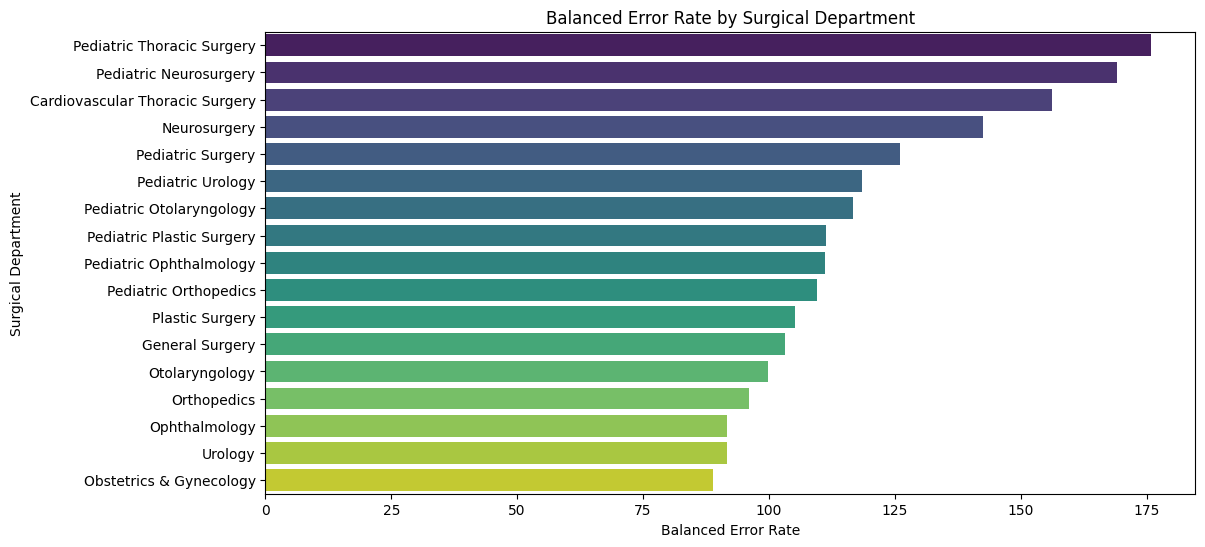

In [ ]:
# Calculating balanced error rate for 'surgical department'
surgical_department_balanced_error_rates = calculate_balanced_error_rate(df_encoded, 'surgical department_')

# Creating DataFrame for visualization
surgical_department_df = pd.DataFrame(surgical_department_balanced_error_rates.items(), columns=['Category', 'Balanced Error Rate'])
surgical_department_df = surgical_department_df.sort_values('Balanced Error Rate', ascending=False)

# Plotting 'Surgical Department' as a horizontal bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Balanced Error Rate', y='Category', data=surgical_department_df, palette="viridis")
plt.title('Balanced Error Rate by Surgical Department')
plt.xlabel('Balanced Error Rate')
plt.ylabel('Surgical Department')
plt.show()



C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36700\3079342358.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Normalized Error Rate', y='Category', data=surgical_department_df, palette="viridis")


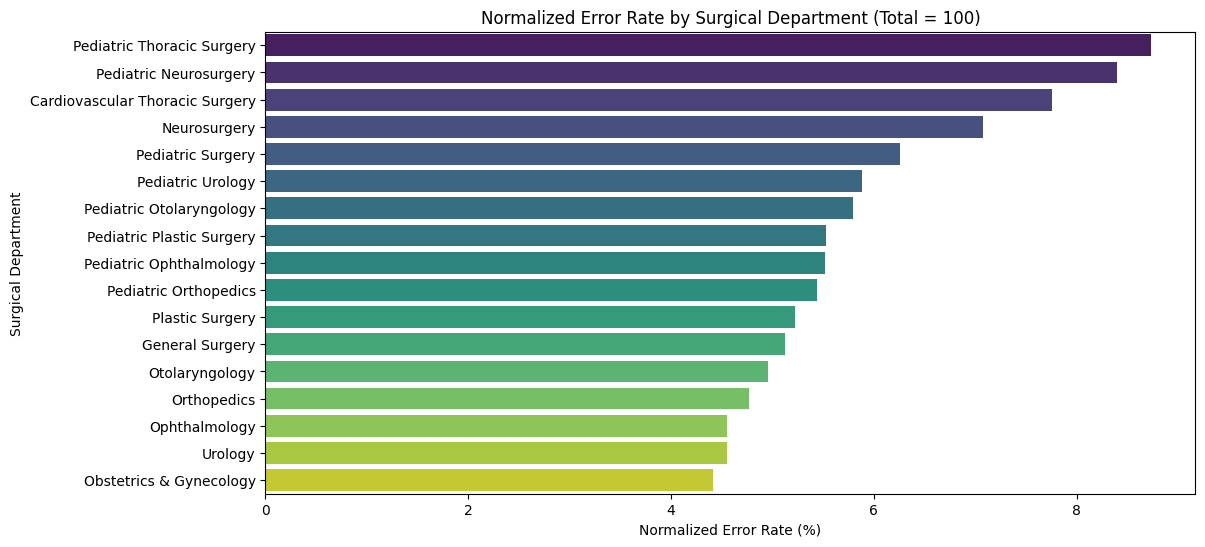

In [ ]:
# 'surgical department' 카테고리에 대한 균형 잡힌 오류율 계산
surgical_department_balanced_error_rates = calculate_balanced_error_rate(df_encoded, 'surgical department_')

# 오류율의 총합으로 각 오류율을 나누고 100을 곱하여 비율로 변환
total_error_rate = sum(surgical_department_balanced_error_rates.values())
normalized_error_rates = {dept: (error_rate / total_error_rate) * 100 for dept, error_rate in surgical_department_balanced_error_rates.items()}

# 시각화를 위한 DataFrame 생성
surgical_department_df = pd.DataFrame(normalized_error_rates.items(), columns=['Category', 'Normalized Error Rate'])
surgical_department_df = surgical_department_df.sort_values('Normalized Error Rate', ascending=False)

# 가로 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Normalized Error Rate', y='Category', data=surgical_department_df, palette="viridis")
plt.title('Normalized Error Rate by Surgical Department (Total = 100)')
plt.xlabel('Normalized Error Rate (%)')
plt.ylabel('Surgical Department')
plt.show()


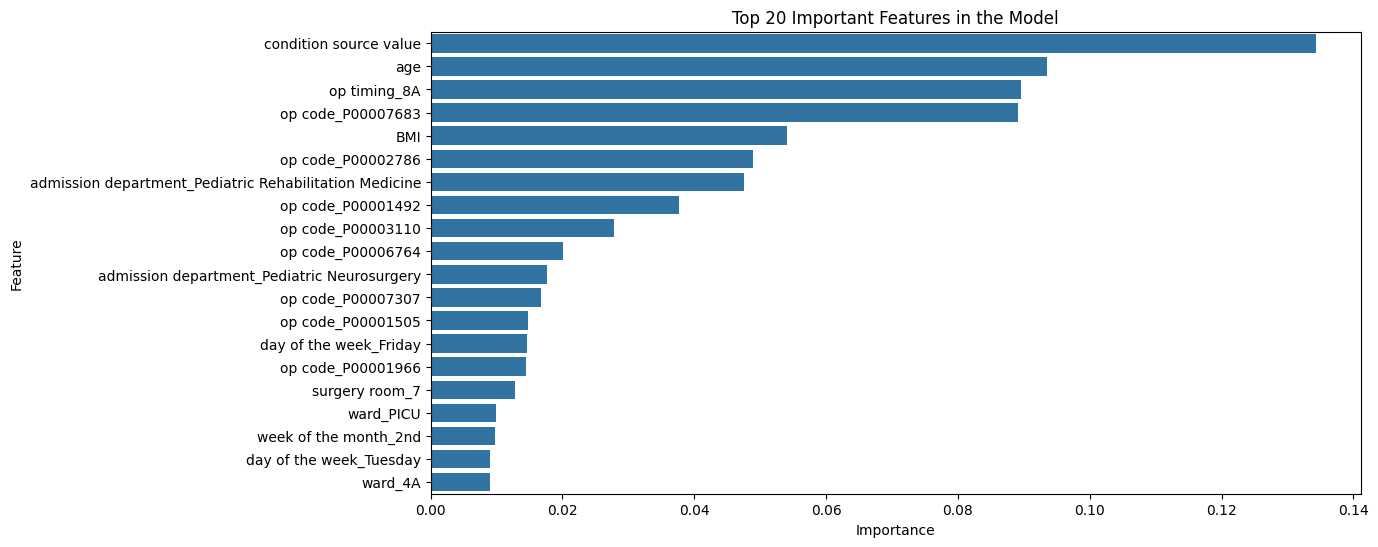

In [ ]:
import seaborn as sns

# Calculating feature importances
feature_importances = department_model.feature_importances_

# Extracting feature names
feature_names = X_train_dept.columns

# Creating a DataFrame for feature importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))
plt.title('Top 20 Important Features in the Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


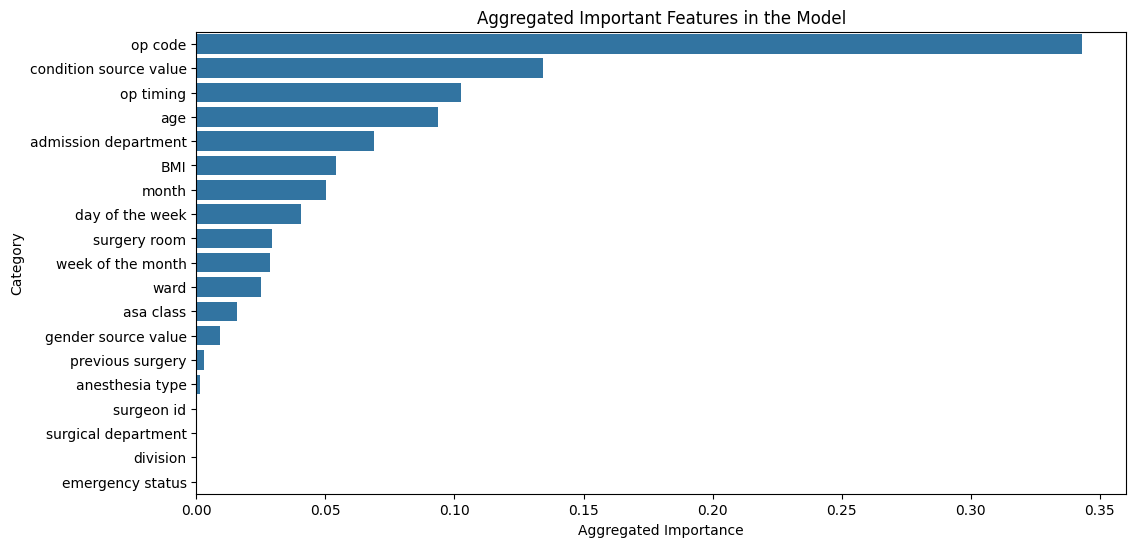

In [ ]:
# 원-핫 인코딩된 피처 그룹의 중요도를 합산
aggregated_importances = {}

for feature, importance in zip(feature_names, feature_importances):
    # 원-핫 인코딩된 피처의 원래 카테고리 이름 추출
    category = feature.split('_')[0]
    
    # 카테고리별 중요도 합산
    if category in aggregated_importances:
        aggregated_importances[category] += importance
    else:
        aggregated_importances[category] = importance

# 카테고리별 중요도를 DataFrame으로 변환
aggregated_importances_df = pd.DataFrame({
    'Category': list(aggregated_importances.keys()),
    'Aggregated Importance': list(aggregated_importances.values())
}).sort_values(by='Aggregated Importance', ascending=False)

# 집계된 중요도를 바 그래프로 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Aggregated Importance', y='Category', data=aggregated_importances_df.head(20))
plt.title('Aggregated Important Features in the Model')
plt.xlabel('Aggregated Importance')
plt.ylabel('Category')
plt.show()


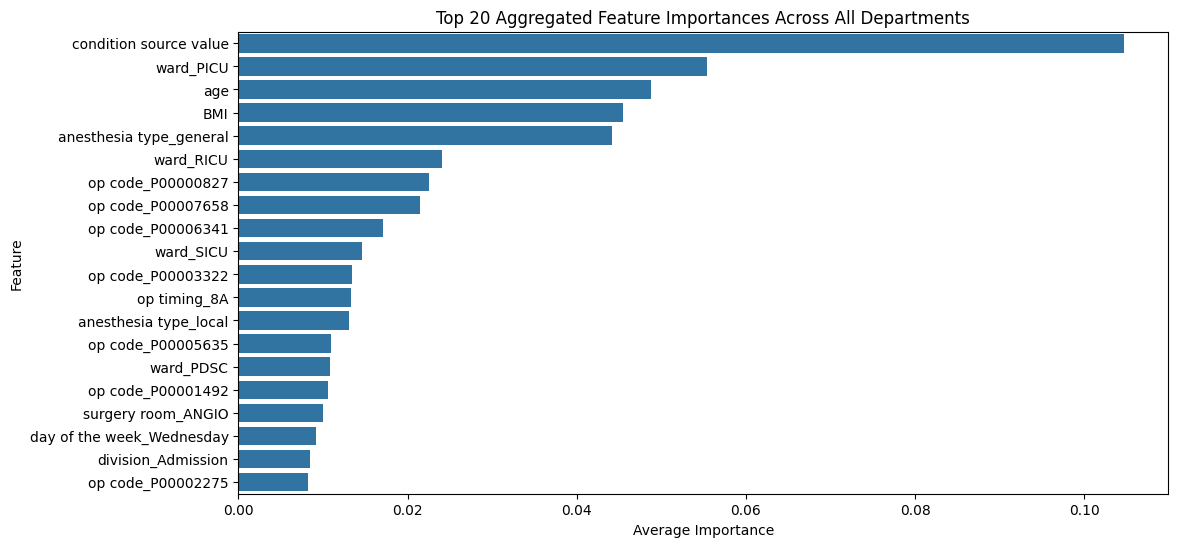

,Feature,Average Importance
2,condition source value,0.104707
314,ward_PICU,0.055448
0,age,0.048757
1,BMI,0.045444
58,anesthesia type_general,0.044134
315,ward_RICU,0.024023
735,op code_P00000827,0.022512
3116,op code_P00007658,0.021433
2676,op code_P00006341,0.017093
316,ward_SICU,0.014614


In [ ]:
import numpy as np

# 각 부서별 모델의 피처 중요도를 저장할 리스트 초기화
all_importances = []

# 각 부서별 모델에 대한 반복 처리
for department, model in department_models.items():
    # 현재 부서의 모델 피처 중요도 추출
    importances = model.feature_importances_
    all_importances.append(importances)

# 모든 부서의 피처 중요도 평균 계산
average_importances = np.mean(all_importances, axis=0)

# 평균 피처 중요도를 DataFrame으로 변환
average_importances_df = pd.DataFrame({
    'Feature': X_train_all.columns,  # X_train_all은 모든 피처 이름을 포함하는 DataFrame
    'Average Importance': average_importances
}).sort_values(by='Average Importance', ascending=False)

# 평균 피처 중요도 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Average Importance', y='Feature', data=average_importances_df.head(20))
plt.title('Top 20 Aggregated Feature Importances Across All Departments')
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.show()

# 평균 피처 중요도 출력
average_importances_df.head(20)


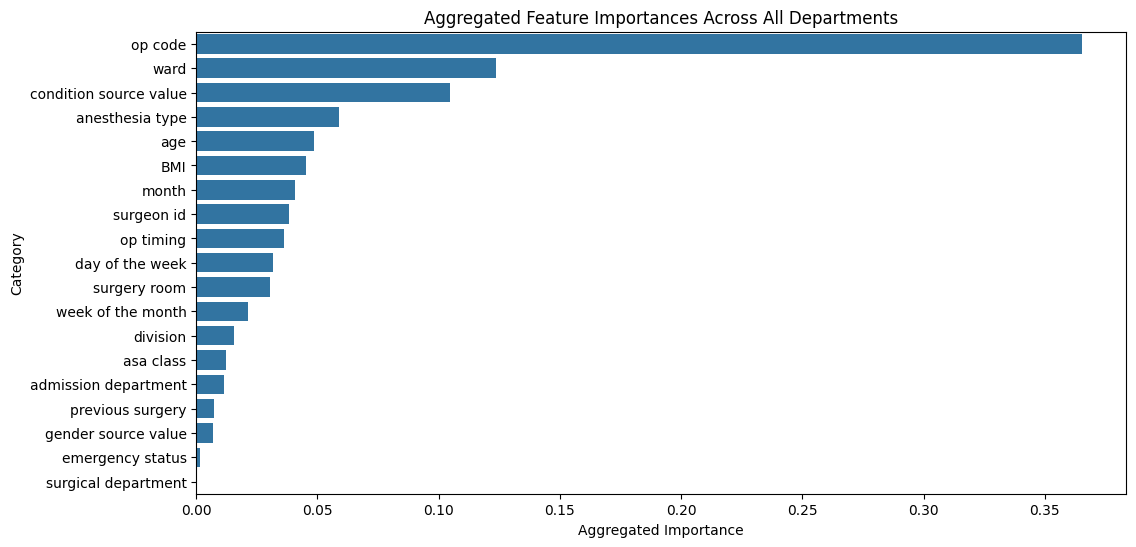

In [ ]:
# 모든 부서의 평균 피처 중요도 계산
average_importances = np.mean(all_importances, axis=0)

# 원-핫 인코딩된 피처 그룹의 중요도를 합산
aggregated_importances = {}

for feature, importance in zip(X_train_all.columns, average_importances):
    # 원-핫 인코딩된 피처의 원래 카테고리 이름 추출
    category = feature.split('_')[0]
    
    # 카테고리별 중요도 합산
    if category in aggregated_importances:
        aggregated_importances[category] += importance
    else:
        aggregated_importances[category] = importance

# 카테고리별 중요도를 DataFrame으로 변환
aggregated_importances_df = pd.DataFrame({
    'Category': list(aggregated_importances.keys()),
    'Aggregated Importance': list(aggregated_importances.values())
}).sort_values(by='Aggregated Importance', ascending=False)

# 집계된 중요도를 바 그래프로 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Aggregated Importance', y='Category', data=aggregated_importances_df.head(20))
plt.title('Aggregated Feature Importances Across All Departments')
plt.xlabel('Aggregated Importance')
plt.ylabel('Category')
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36700\3491349418.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Aggregated Importance', y='Category', data=aggregated_importances_df.head(20), palette=palette)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36700\3491349418.py:30: UserWarning: 
The palette list has fewer values (10) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Aggregated Importance', y='Category', data=aggregated_importances_df.head(20), palette=palette)


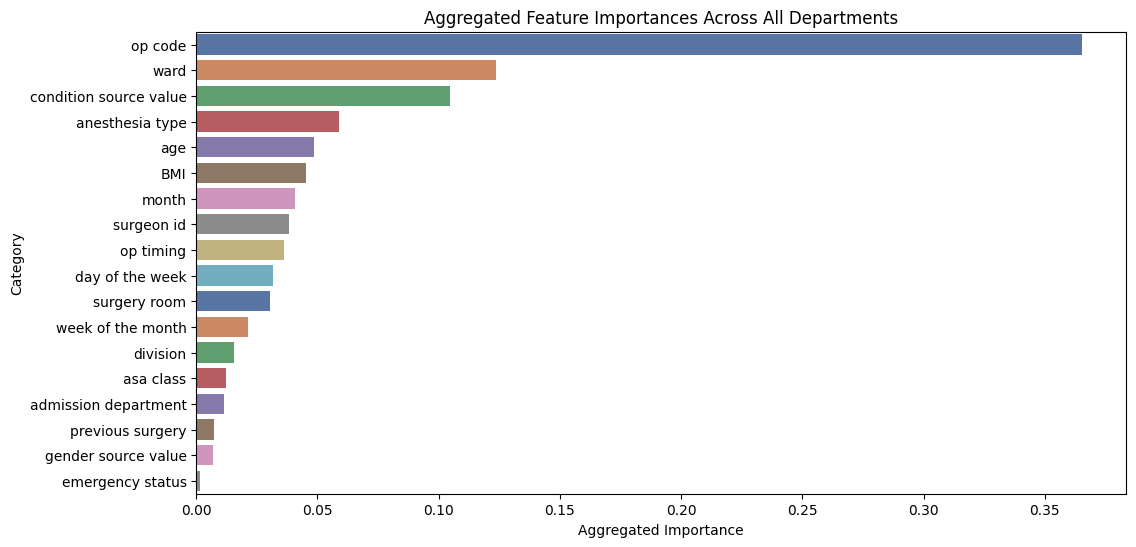

,Category,Aggregated Importance
17,op code,0.365366
14,ward,0.123691
2,condition source value,0.104707
5,anesthesia type,0.058743
0,age,0.048757
1,BMI,0.045444
4,month,0.040637
13,surgeon id,0.038159
3,op timing,0.036347
6,day of the week,0.031502


In [ ]:
# 모든 부서의 평균 피처 중요도 계산
average_importances = np.mean(all_importances, axis=0)

# 원-핫 인코딩된 피처 그룹의 중요도를 합산 (단, 'surgical department' 제외)
aggregated_importances = {}

for feature, importance in zip(X_train_all.columns, average_importances):
    # 원-핫 인코딩된 피처의 원래 카테고리 이름 추출
    category = feature.split('_')[0]
    
    # 'surgical department' 카테고리는 제외
    if category != 'surgical department':
        # 카테고리별 중요도 합산
        if category in aggregated_importances:
            aggregated_importances[category] += importance
        else:
            aggregated_importances[category] = importance

# Seaborn의 색상 팔레트 설정
palette = sns.color_palette("deep")

# 카테고리별 중요도를 DataFrame으로 변환
aggregated_importances_df = pd.DataFrame({
    'Category': list(aggregated_importances.keys()),
    'Aggregated Importance': list(aggregated_importances.values())
}).sort_values(by='Aggregated Importance', ascending=False)

# 집계된 중요도를 바 그래프로 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Aggregated Importance', y='Category', data=aggregated_importances_df.head(20), palette=palette)
plt.title('Aggregated Feature Importances Across All Departments')
plt.xlabel('Aggregated Importance')
plt.ylabel('Category')
plt.show()

# 집계된 중요도 상위 20개 출력
aggregated_importances_df.head(20)
